In [1]:
import sys
import os
from pathlib import Path 

# Add project root to path to allow importing src
current_dir = Path.cwd()
if current_dir.name == "notebooks":
    sys.path.append(str(current_dir.parent))
else:
    sys.path.append(str(current_dir))

import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

from src.monotone_grad_nets.models import cmgn, icgn, icnn, mmgn
from src.monotone_grad_nets.trainers import trainer
from src.monotone_grad_nets.utils.plotting import plot_distribution_comparison

from importlib import reload

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Dataset:

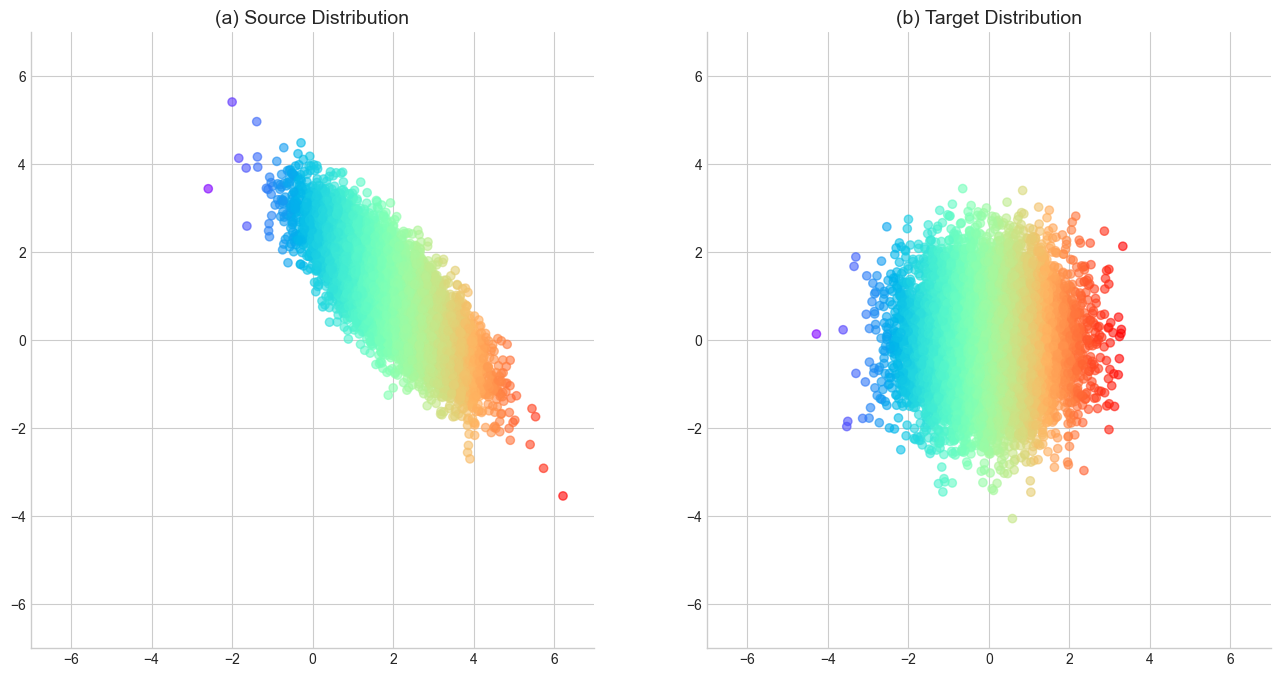

In [2]:
# Set random seed
torch.manual_seed(42)

# we start by generating samples from a N(0, 1) and then apply the transformation Ax + µ to get the desired source distribution (using Cholesky decomposition)
mean_source = torch.tensor([2.0, 1.0])
cov_source = torch.tensor([[1.0, -0.8], [-0.8, 1.0]])

L = torch.linalg.cholesky(cov_source)
x = torch.randn(10_000, 2) @ L.T + mean_source
y = torch.randn(10_000, 2)

# Visualize both distributions
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.scatter(x[:,0], x[:,1], c=x[:,0], cmap="rainbow", alpha=0.6)
plt.xlim(-7, 7)
plt.ylim(-7, 7)
plt.title("(a) Source Distribution")

plt.subplot(1,2,2)
plt.scatter(y[:,0], y[:,1], c=y[:,0], cmap="rainbow", alpha=0.6)
plt.xlim(-7, 7)
plt.ylim(-7, 7)
plt.title("(b) Target Distribution")

plt.show()


In [3]:
# Create dataset and DataLoader
dataset = TensorDataset(x, y)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


**Closed form Solution for Optimal Coupling of Gaussian Distributions for the Wasserstein Distance:**

In [4]:
# we start by generating samples from a N(0, 1) and then apply the transformation Ax + µ to get the desired source distribution (using Cholesky decomposition)
mean_source = torch.tensor([2.0, 1.0])
cov_source = torch.tensor([[1.0, -0.8], [-0.8, 1.0]])

L = torch.linalg.cholesky(cov_source)
x = torch.randn(10_000, 2) @ L.T + mean_source

def g(x):
    L_inv = torch.linalg.inv(L)
    return (x - mean_source) @ L_inv.T

transported_dist = g(x).numpy()

### Models:

In [5]:
input_dim = 2
output_dim = 2

# Models suggested by the Ppaer
model_CMGN = cmgn.C_MGN(input_dim=input_dim, hidden_dim=2, num_layers=2, output_dim=output_dim, ortho=True).to(device)

model_MMGN = mmgn.M_MGN(input_dim=input_dim, hidden_dim=3, num_layers=2).to(device)

# Benchmark Models
model_ICGN = icgn.I_CGN(input_dim=input_dim, hidden_dim=5, num_layers=1).to(device)
model_ICNN = icnn.I_CNN(input_dim=input_dim, hidden_dim=1, num_layers=19).to(device)

print("Number of parameters in C-MGN", sum(p.size().numel() for p in model_CMGN.parameters()))
print("Number of parameters in M-MGN", sum(p.size().numel() for p in model_MMGN.parameters()))
print("Number of parameters in I-CGN", sum(p.size().numel() for p in model_ICGN.parameters()))
print("Number of parameters in I-CNN", sum(p.size().numel() for p in model_ICNN.parameters()))

Number of parameters in C-MGN 14
Number of parameters in M-MGN 24
Number of parameters in I-CGN 15
Number of parameters in I-CNN 76


### Models Training and Results:

### CMGN:

Epoch 50 | Train Loss: 2.3368 | Train Cost: 5.4831 | : 100%|██████████| 50/50 [36:54<00:00, 44.30s/it]


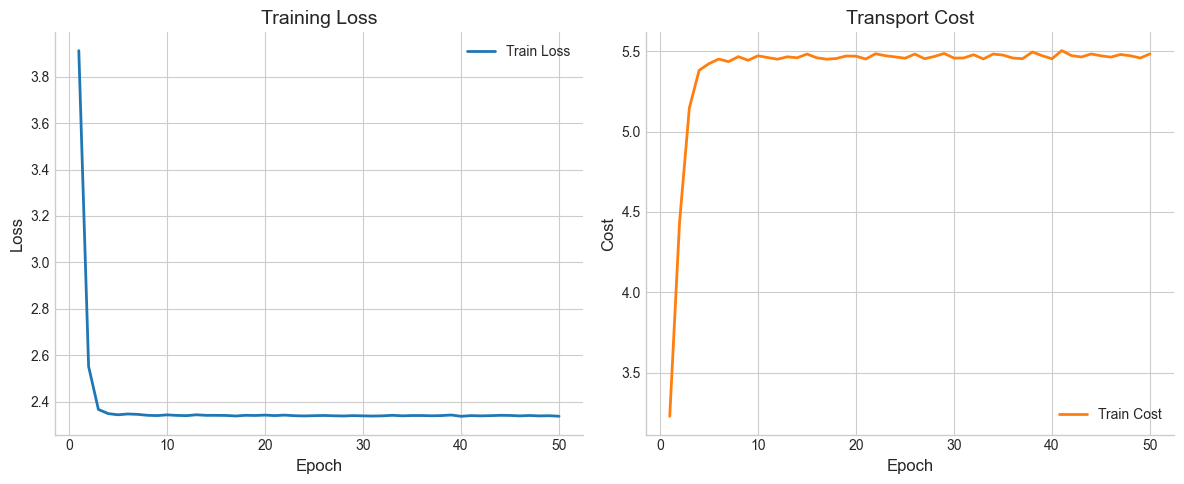

In [6]:
# Initialize the model and trainer
cmgn_trainer = trainer.Trainer(
    task='optimal_transport',
    model=model_CMGN,
    criterion='nll',
    use_amp=True if torch.cuda.is_available() else False,
    accumulation_steps=1,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Train the model
cmgn_trainer.train(train_loader)
cmgn_trainer.plot_train_metrics(plot_cost=True)

**Comparing Model Output to the closed-form solution for the Wasserstein Distance**

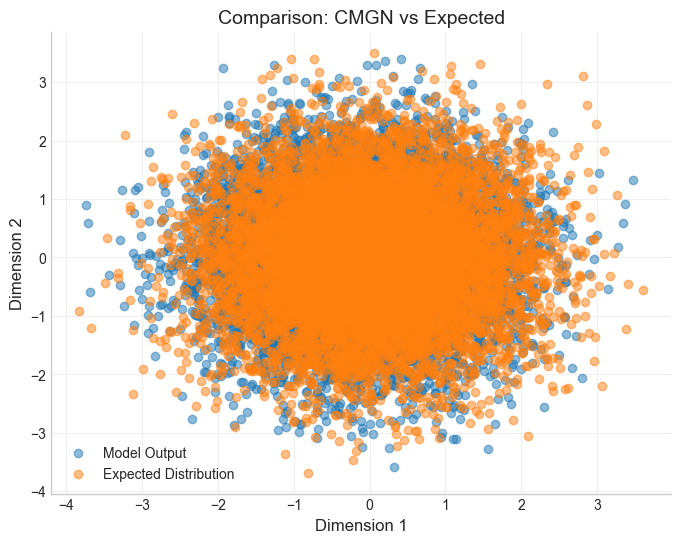

In [10]:
plot_distribution_comparison(cmgn_trainer.model(x).detach().cpu().numpy(), transported_dist, model_name='CMGN')

### MMGN:

Epoch 50 | Train Loss: 2.3415 | Train Cost: 5.4809 | : 100%|██████████| 50/50 [35:19<00:00, 42.38s/it]


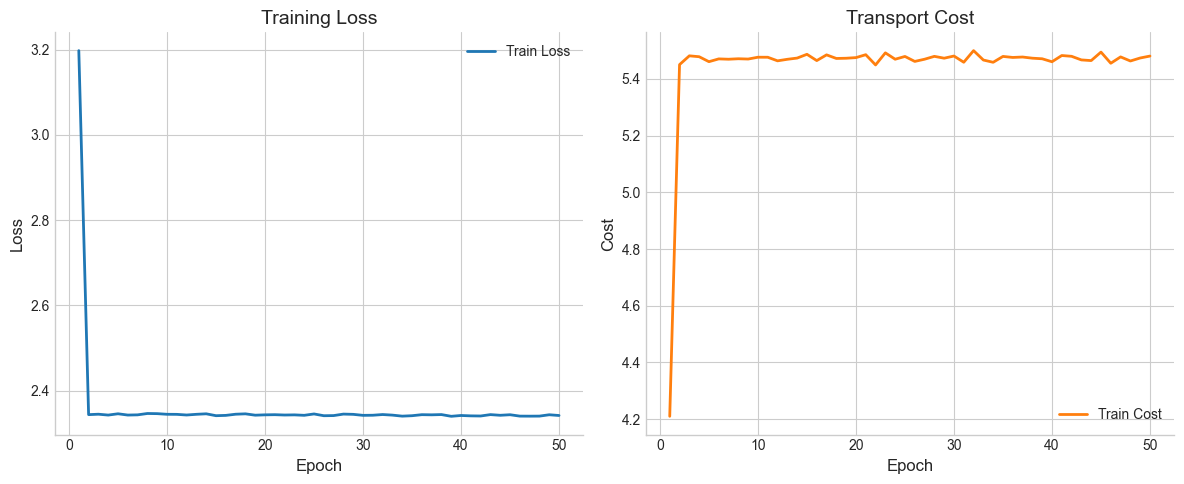

In [11]:
# Initialize the model and trainer
mmgn_trainer = trainer.Trainer(
    task='optimal_transport',
    model=model_MMGN,
    criterion='nll',
    use_amp=True if torch.cuda.is_available() else False,
    accumulation_steps=1,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Train the model
mmgn_trainer.train(train_loader)
mmgn_trainer.plot_train_metrics(plot_cost=True)

**Comparing Model Output to the closed-form solution for the Wasserstein Distance**

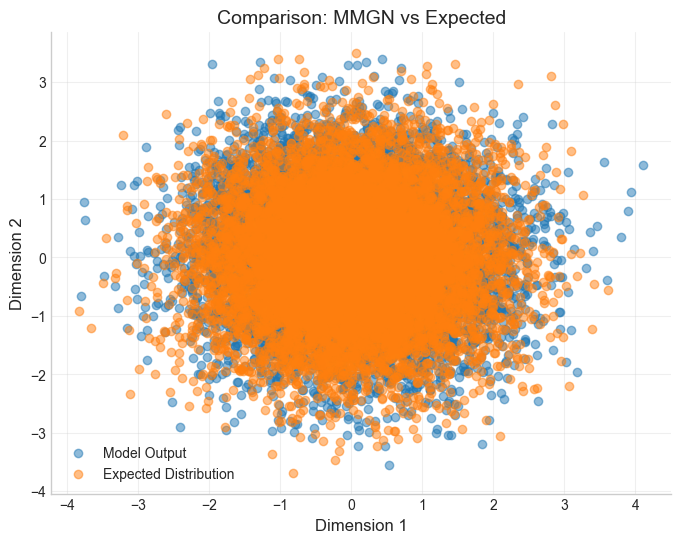

In [12]:
plot_distribution_comparison(mmgn_trainer.model(x).cpu().detach().numpy(), transported_dist, model_name='MMGN')